## Residual Network Practice with Pytorch

이 note에서는 ResNet 논문을 기반으로 ResNet의 성능을 Testing 해본다.


### 사용할 학습 데이터
- ImageNet
- CIFAR-10

### 사용할 모델
- ImageNet dataset
  - Pre-trained Model
- CIFAR-10
  - Plain Net - 20, 56
  - ResNet - 20, 56

In [ ]:
# Library Import

import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [ ]:
# GPU setting
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

ImageNet 클래스(1000개) 정보 가져오기

In [ ]:
from urllib.request import urlretrieve
import json

# ImageNet dataset class값 가져오기
imagenet_json, _ = urlretrieve('https://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
  imagenet_labels = json.load(f)

In [ ]:
# testing code
print(imagenet_labels[0])

tench, Tinca tinca


Data 전처리는 논문과 같이 처리한다.  
  
"The image is resized with its shorter side randomly sampled in [256, 480] for scale augmentation [41].
A 224×224 crop is randomly sampled from an image or its
horizontal flip"(page 4)

In [ ]:
preprocess = transforms.Compose([
                                 transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor() #PIL 혹은 np.array를 tensor로 바꾸어준다.
])

In [ ]:
# image plotting
import matplotlib.pyplot as plt
import PIL

In [ ]:
# 경로로 부터 이미지를 받아와 preprocess 단계를 거쳐 tensor로 변환
def image_loader(path):
  image = PIL.Image.open(path)
  # 전처리를 거친 후 network 입력단에 들어갈 배치 목적의 차원 추가 (가로, 세로, 채널) => (배치, 가로, 세로, 채널)
  image = preprocess(image).unsqueeze(0)
  # 처리된 image를 device에 등록
  return image.to(device, torch.float)

In [ ]:
# Preprocessing testing

image_path = './drive/MyDrive/Dev-dl/cat.jpg'
image = image_loader(image_path)

In [ ]:
#Test Image Plotting

def imshow(tensor):
  #matplotlib는 GPU를 지원하지 않으므로 CPU로 이동
  image = tensor.cpu().clone()
  #맨 앞 차원(배치) 제거
  image = image.squeeze(0)
  # PIL 객체로 변경
  image = transforms.ToPILImage()(image)
  plt.imshow(image)

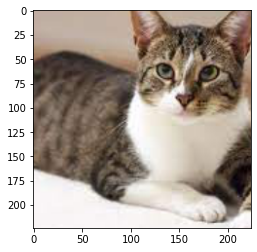

In [ ]:
plt.figure()
imshow(image)

###Pretrained 모델 불러오기

- ImageNet dataset은 데이터 크기가 매우 크기 때문에 새로 학습을 시키는 것은 시간 상 생략


In [ ]:
# input data normalization class
class Normalize(nn.Module):
  def __init__(self, mean, std):
    super(Normalize, self).__init__()
    #Normalize method => Standardization
    self.register_buffer('mean', torch.Tensor(mean))
    self.register_buffer('std', torch.Tensor(std))

  def forward(self, input):
    mean = self.mean.reshape(1, 3, 1, 1)
    std = self.std.reshape(1, 3, 1, 1)
    return (input - mean)/std

In [ ]:
# 모델 실행시 input에 대한 Normalize 수행 후 실행
model = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
).to(device).eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [ ]:
# Test image를 넣어 Prediction 수행
outputs = model(image)
percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
# 가장 높은 값을 가지는 5개의 인덱스와 그 확률을 출력
print("결과")
for i in outputs[0].topk(5)[1]:
  print(f'인덱스: {i.item()}, 클래스명: {imagenet_labels[i]}, 확률: {round(percentages[i].item(),4)}%')

결과
인덱스: 281, 클래스명: tabby, tabby cat, 확률: 55.0171%
인덱스: 285, 클래스명: Egyptian cat, 확률: 33.24%
인덱스: 282, 클래스명: tiger cat, 확률: 11.1233%
인덱스: 728, 클래스명: plastic bag, 확률: 0.0874%
인덱스: 287, 클래스명: lynx, catamount, 확률: 0.0659%


## 다음으로 CIFAR-10 DATASET을 대상으로 실제 RESNET 모델을 Build 해보고 학습해본다

In [ ]:
# Library import
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import os

In [ ]:
# Residual Block class
class ResidualBlock(nn.Module):
  #in_plane : input의 dimension, planes: output의 dimension)
  def __init__(self, in_planes, planes, stride=1):
    #ResidualBlock 호출 시 nn.Module 호출
    super(ResidualBlock, self).__init__()
    # Convolution layer 정의
    # Residual block은 두 개의 3x3 Conv layer로 구성되어 있으며 Conv => BN => Activation 과정을 거친다
    # 논문에 따라 bias는 False로 지정
    
    # 첫 번째 Convolution Layer in Residual block
    # filter 수가 2배씩 증가하므로 너비 x 높이를 2배로 줄이고자 할때는 pooling이 아닌 stride를 2로 조정
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    # Conv layer를 거쳐 나온 output을 Batch Normalize
    self.bn1 = nn.BatchNorm2d(planes)

    # 두 번째 Convolution Layer in Residual block
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    
    # Stride = 1일 경우 input dimension == output dimension => identity mapping 수행
    # argument가 없이 nn.Sequential()을 호출할 경우 identity mapping 수행
    self.shortcut = nn.Sequential()
    # Stride = 2일 경우 input dimension != output dimension => stride=2, 1x1 합성곱망을 거치도록 함
    if stride != 1:
      self.shortcut = nn.Sequential(
          #여기서 planes가 아닌 in_planes가 들어가는 이유
            #shortcut은 input에 대해 identity mapping을 하는 것이므로 input의 dimension을 받는다
          nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(planes)
      )
  #순전파 순서 정의
  def forward(self, x):
    # Conv => BN => Activation 순으로 진행
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    #shortcut connection
    out += self.shortcut(x)
    out = F.relu(out)
    return out


### 레이어 구성 목표

1. The first layer is 3×3 convolutions.
2. Then we use a stack of 6n layers with 3×3 convolutions on the feature maps of sizes {32, 16, 8} respectively,
with 2n layers for each feature map size. The numbers of
filters are {16, 32, 64} respectively.
3. The network ends
with a global average pooling, a 10-way fully-connected
layer, and softmax. 
4. Plain Net - 20, 56 / ResNet - 20, 56

In [ ]:
# ResNet 전체 Network 구성하는 Class
class ResNet(nn.Module):
  #CIFAR-10 데이터셋의 클래스 10개에 맞추어 Parameter 조정
  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes = 16

    # ImageNet 처리 시 가장 앞 단에 layer 7x7, maxPooling 층을 두었으나
    # 3의 input dimension(RGB)를 받아 64개 feature map 생성
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(16)
    self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
    self.linear = nn.Linear(64, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    #num_blocks의 갯수 만큼 strides 리스트에 넣는다 => list의 length만큼 layer 내에 block 만든다
    strides = [stride] + [1] * (num_blocks - 1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes # 다음 layer로 넘어갈때 채널 수 맞춰주기
    # *args: 가변 갯수의 인자를 함수에 집어넣어 줌
    return nn.Sequential(*layers)
  
  #순전파 방식
  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out) #out: [batch_size, 64, 8,8]
    #1x1로 바꿔주기 위해서 8x8 maxpolling
    out = F.avg_pool2d(out, 8)
    # view: pytorch에서 reshape과 같은 역할을 함
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

In [ ]:
# ResNet20 함수 정의
def ResNet20():
  # 2개의 convolution layer 으로 구성된 블록이 layer마다 3개 있으므로 전체 레이어는 6n개
  return ResNet(ResidualBlock, [3,3,3])

### CIFAR-10 DATASET LOADING

1. for training: 4 pixels are padded on each side,
and a 32×32 crop is randomly sampled from the padded
image or its horizontal flip
2. For testing, we only evaluate
the single view of the original 32×32 image

3.  These models are trained with a minibatch size of 128 on two GPUs. 

In [ ]:
transform_train = transforms.Compose([
                                      # 1번 조건
                                      transforms.RandomCrop(32, padding=4),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
])

transform_test = transforms.Compose([
                                     # 2번 조건: test dataset에 대해서는 augument 진행 X
                                     transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root='./drive/MyDrive/Dev-dl/data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./drive/MyDrive/Dev-dl/data/', train=False, download=True, transform=transform_test)
# Overfitting을 피하기 위해 shuffle=True로 지정해준다. (매 epoch마다 데이터셋 섞음)
# two GPU사용
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### 환경설정 및 학습 함수 정의

1. We use a weight decay of 0.0001 and momentum of 0.9,
and adopt the weight initialization in [13] and BN [16] but
with no dropout.

2. We start with a learning
rate of 0.1, divide it by 10 at 32k and 48k iterations, and
terminate training at 64k iterations, which is determined on
a 45k/5k train/val split.

In [ ]:
device ='cuda'

#신경망 선언
net = ResNet20()

#신경망 GPU loading
net = net.to(device) 

learning_rate = 0.1
file_name = 'resnet20_cifar.pth'

# loss function => Cross-Entropy-Loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)

#학습 정의

def train(epoch):
  print('Epoch: %d'%epoch)
  net.train()
  train_loss = 0
  correct = 0
  total = 0

  for batch_idx, (inputs, targets) in enumerate(train_loader):
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, targets)
    # loss back propagation
    loss.backward()

    optimizer.step()
    train_loss += loss.item()
    writer.add_scalar("Loss/ResNet20-train", train_loss, epoch)
    _, predicted = outputs.max(1)
    #전체 갯수 count
    total += targets.size(0)
    #맞은 갯수 count
    current_correct = predicted.eq(targets).sum().item()
    correct += current_correct

    # #100 batch 마다 정확도 출력
    # if batch_idx % 100 == 0:
    #   print('\nCurrent batch:', str(batch_idx))
    #   print('Current batch average train accuracy:', current_correct / targets.size(0))
    #   print('Current batch average train loss:', loss.item() / targets.size(0))

  print('\nTotal average train accuracy:', correct / total)
  print('Total average train loss:', train_loss / total)

# 평가 정의

def test(epoch):
  print('\n Test epoch: %d'%epoch)
  net.eval()
  loss = 0
  correct = 0
  total = 0

  for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()
        writer.add_scalar("Loss/ResNet20-test", loss, epoch)
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

  print('\nTotal average test accuarcy:', correct / total)
  print('Total average test loss:', loss / total)

  state = {
        'net' : net.state_dict()
    }
  if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')
  torch.save(state, './checkpoint' + file_name)
  print('모델이 저장되었습니다')

[1, 1, 1]
16
16
16
16
16
16
[2, 1, 1]
16
32
32
32
32
32
[2, 1, 1]
32
64
64
64
64
64


### Training

In [ ]:
import time

def adjust_learning_rate(optimizer, epoch):
  lr = learning_rate
  # iteration in 1 epoch = train_data size / batch size = 45000/128 = 약 350
  # 32000, 48000에서 lr update => 32000/350 = 약 90번째 epoch, 48000/350 = 137번째 epoch
  if epoch >=90:
    lr /= 10
  if epoch >= 137:
    lr /= 10
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

start_time = time.time()

for epoch in range(0,150):
  adjust_learning_rate(optimizer, epoch)
  train(epoch)
  test(epoch)
  print('\n경과 시간:', time.time()-start_time)

Epoch: 0

Total average train accuracy: 0.37112
Total average train loss: 0.0130403590965271

 Test epoch: 0

Total average test accuarcy: 0.4791
Total average test loss: 0.014729096579551697

경과 시간: 16.607301712036133
Epoch: 1

Total average train accuracy: 0.58458
Total average train loss: 0.008958596982955933

 Test epoch: 1

Total average test accuarcy: 0.5178
Total average test loss: 0.01462576711177826

경과 시간: 33.1825065612793
Epoch: 2

Total average train accuracy: 0.66898
Total average train loss: 0.007254592483043671

 Test epoch: 2

Total average test accuarcy: 0.6591
Total average test loss: 0.009767863124608993

경과 시간: 49.70162224769592
Epoch: 3

Total average train accuracy: 0.7249
Total average train loss: 0.006134643958806992

 Test epoch: 3

Total average test accuarcy: 0.7257
Total average test loss: 0.007969421565532684

경과 시간: 66.3463351726532
Epoch: 4

Total average train accuracy: 0.76084
Total average train loss: 0.005370581101775169

 Test epoch: 4

Total average

### ResNet-56 Testing

In [ ]:
def ResNet56():
  return ResNet(ResidualBlock, [9,9,9])

In [ ]:
#신경망 선언
net = ResNet56()

#신경망 GPU loading
net = net.to(device) 

learning_rate = 0.1
file_name = 'resnet50_cifar.pth'

# loss function => Cross-Entropy-Loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)

#학습 정의

def train(epoch):
  print('Epoch: %d'%epoch)
  net.train()
  train_loss = 0
  correct = 0
  total = 0

  for batch_idx, (inputs, targets) in enumerate(train_loader):
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, targets)
    # loss back propagation
    loss.backward()

    optimizer.step()
    train_loss += loss.item()
    writer.add_scalar("Loss/ResNet56-train", train_loss, epoch)
    _, predicted = outputs.max(1)
    #전체 갯수 count
    total += targets.size(0)
    #맞은 갯수 count
    current_correct = predicted.eq(targets).sum().item()
    correct += current_correct

    # 100 batch 마다 정확도 출력
    # if batch_idx % 100 == 0:
    #   print('\nCurrent batch:', str(batch_idx))
    #   print('Current batch average train accuracy:', current_correct / targets.size(0))
    #   print('Current batch average train loss:', loss.item() / targets.size(0))

  print('\nTotal average train accuracy:', correct / total)
  print('Total average train loss:', train_loss / total)

# 평가 정의

def test(epoch):
  print('\n Test epoch: %d'%epoch)
  net.eval()
  loss = 0
  correct = 0
  total = 0

  for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()
        writer.add_scalar("Loss/ResNet56-test", loss, epoch)
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

  print('\nTotal average test accuarcy:', correct / total)
  print('Total average test loss:', loss / total)

  state = {
        'net' : net.state_dict()
    }
  if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')
    torch.save(state, './checkpoint' + file_name)
    print('모델이 저장되었습니다')

[1, 1, 1, 1, 1, 1, 1, 1, 1]
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
[2, 1, 1, 1, 1, 1, 1, 1, 1]
16
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
[2, 1, 1, 1, 1, 1, 1, 1, 1]
32
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64


In [ ]:
import time
def adjust_learning_rate(optimizer, epoch):
  lr = learning_rate
  # iteration in 1 epoch = train_data size / batch size = 45000/128 = 약 350
  # 32000, 48000에서 lr update => 32000/350 = 약 90번째 epoch, 48000/350 = 137번째 epoch
  if epoch >=90:
    lr /= 10
  if epoch >= 137:
    lr /= 10
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

start_time = time.time()

for epoch in range(0,150):
  adjust_learning_rate(optimizer, epoch)
  train(epoch)
  test(epoch)
  print('\n경과 시간:', time.time()-start_time)

Epoch: 0

Total average train accuracy: 0.279
Total average train loss: 0.015149434731006623

 Test epoch: 0

Total average test accuarcy: 0.3715
Total average test loss: 0.0173614963889122
모델이 저장되었습니다

경과 시간: 39.779345989227295
Epoch: 1

Total average train accuracy: 0.41548
Total average train loss: 0.012324053344726563

 Test epoch: 1

Total average test accuarcy: 0.4685
Total average test loss: 0.01425133080482483

경과 시간: 80.5691978931427
Epoch: 2

Total average train accuracy: 0.52828
Total average train loss: 0.010144297090768814

 Test epoch: 2

Total average test accuarcy: 0.55
Total average test loss: 0.012869881367683411

경과 시간: 122.29723906517029
Epoch: 3

Total average train accuracy: 0.62408
Total average train loss: 0.00820945801615715

 Test epoch: 3

Total average test accuarcy: 0.5901
Total average test loss: 0.011495314401388169

경과 시간: 163.7708296775818
Epoch: 4

Total average train accuracy: 0.69466
Total average train loss: 0.0067327895081043245

 Test epoch: 4

To

#### Plain-20 Net Testing


In [ ]:
# Plain Block class
# Residual Block에서 shortcut connection 부분만 제외시키고 나머지는 동일하게 한다.
class Block(nn.Module):
  #in_plane : input의 dimension, planes: output의 dimension)
  def __init__(self, in_planes, planes, stride=1):
    #Block 호출 시 nn.Module 호출
    super(Block, self).__init__()
    # Convolution layer 정의
    # Plain block은 두 개의 3x3 Conv layer로 구성되어 있으며 Conv => BN => Activation 과정을 거친다
    # 논문에 따라 bias는 False로 지정
    
    # 첫 번째 Convolution Layer in Plain Block
    # filter 수가 2배씩 증가하므로 너비 x 높이를 2배로 줄이고자 할때는 pooling이 아닌 stride를 2로 조정
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    # Conv layer를 거쳐 나온 output을 Batch Normalize
    self.bn1 = nn.BatchNorm2d(planes)

    # 두 번째 Convolution Layer in Plain Block
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    
  #순전파 순서 정의
  def forward(self, x):
    # Conv => BN => Activation 순으로 진행
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out = F.relu(out)
    return out


In [ ]:
# PlainNet 전체 Network 구성하는 Class
class PlainNet(nn.Module):
  #CIFAR-10 데이터셋의 클래스 10개에 맞추어 Parameter 조정
  def __init__(self, block, num_blocks, num_classes=10):
    super(PlainNet, self).__init__()
    self.in_planes = 16

    # 3의 input dimension(RGB)를 받아 16개 feature map 생성
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(16)
    self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
    self.linear = nn.Linear(64, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    #num_blocks의 갯수 만큼 strides 리스트에 넣는다 => list의 length만큼 layer 내에 block 만든다
    strides = [stride] + [1] * (num_blocks - 1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes # 다음 layer로 넘어갈때 채널 수 맞춰주기
    # *args: 가변 갯수의 인자를 함수에 집어넣어 줌
    return nn.Sequential(*layers)
  
  #순전파 방식
  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out) #out: [batch_size, 64, 8,8]
    #1x1로 바꿔주기 위해서 8x8 maxpolling
    out = F.avg_pool2d(out, 8)
    # view: pytorch에서 reshape과 같은 역할을 함
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

In [ ]:
# Plain Net-20 함수 정의
def PlainNet20():
  # 2개의 convolution layer 으로 구성된 블록이 layer마다 3개 있으므로 전체 레이어는 6n개
  return PlainNet(Block, [3,3,3])

In [ ]:
#신경망 선언
net = PlainNet20()

#신경망 GPU loading
net = net.to(device) 

learning_rate = 0.1
file_name = 'plain20_cifar.pth'

# loss function => Cross-Entropy-Loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)

#학습 정의

def train(epoch):
  print('Epoch: %d'%epoch)
  net.train()
  train_loss = 0
  correct = 0
  total = 0

  for batch_idx, (inputs, targets) in enumerate(train_loader):
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, targets)
    # loss back propagation
    loss.backward()

    optimizer.step()
    train_loss += loss.item()
    writer.add_scalar("Loss/Plain20-train", train_loss, epoch)
    _, predicted = outputs.max(1)
    #전체 갯수 count
    total += targets.size(0)
    #맞은 갯수 count
    current_correct = predicted.eq(targets).sum().item()
    correct += current_correct

    #100 batch 마다 정확도 출력
    # if batch_idx % 100 == 0:
    #   print('\nCurrent batch:', str(batch_idx))
    #   print('Current batch average train accuracy:', current_correct / targets.size(0))
    #   print('Current batch average train loss:', loss.item() / targets.size(0))

  print('\nTotal average train accuracy:', correct / total)
  print('Total average train loss:', train_loss / total)

# 평가 정의

def test(epoch):
  print('\n Test epoch: %d'%epoch)
  net.eval()
  loss = 0
  correct = 0
  total = 0

  for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()
        writer.add_scalar("Loss/Plain20-test", loss, epoch)
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

  print('\nTotal average test accuarcy:', correct / total)
  print('Total average test loss:', loss / total)

  state = {
        'net' : net.state_dict()
    }
  if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')
    torch.save(state, './checkpoint' + file_name)
    print('모델이 저장되었습니다')

[1, 1, 1]
16
16
16
16
16
16
[2, 1, 1]
16
32
32
32
32
32
[2, 1, 1]
32
64
64
64
64
64


In [ ]:
def adjust_learning_rate(optimizer, epoch):
  lr = learning_rate
  # iteration in 1 epoch = train_data size / batch size = 45000/128 = 약 350
  # 32000, 48000에서 lr update => 32000/350 = 약 90번째 epoch, 48000/350 = 137번째 epoch
  if epoch >=90:
    lr /= 10
  if epoch >= 137:
    lr /= 10
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

start_time = time.time()

for epoch in range(0,150):
  adjust_learning_rate(optimizer, epoch)
  train(epoch)
  test(epoch)
  print('\n경과 시간:', time.time()-start_time)

Epoch: 0

Total average train accuracy: 0.29128
Total average train loss: 0.014599162085056305

 Test epoch: 0

Total average test accuarcy: 0.3126
Total average test loss: 0.0204616308093071

경과 시간: 15.953054428100586
Epoch: 1

Total average train accuracy: 0.43698
Total average train loss: 0.011952872285842896

 Test epoch: 1

Total average test accuarcy: 0.4074
Total average test loss: 0.01750745793581009

경과 시간: 31.879066228866577
Epoch: 2

Total average train accuracy: 0.547
Total average train loss: 0.009807555528879165

 Test epoch: 2

Total average test accuarcy: 0.5014
Total average test loss: 0.014287088298797608

경과 시간: 47.821603536605835
Epoch: 3

Total average train accuracy: 0.63224
Total average train loss: 0.008154440177679061

 Test epoch: 3

Total average test accuarcy: 0.6196
Total average test loss: 0.010738597893714905

경과 시간: 63.71850895881653
Epoch: 4

Total average train accuracy: 0.67786
Total average train loss: 0.007187452507019043

 Test epoch: 4

Total aver

KeyboardInterrupt: ignored

### Plain-56 NET Testing


In [ ]:
# PlainNet-56 함수 정의
def PlainNet56():
  # 2개의 convolution layer 으로 구성된 블록이 layer마다 3개 있으므로 전체 레이어는 6n개
  return PlainNet(Block, [9,9,9])

In [ ]:
#신경망 선언
net = PlainNet56()

#신경망 GPU loading
net = net.to(device) 

learning_rate = 0.1
file_name = 'plain56_cifar.pth'

# loss function => Cross-Entropy-Loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)

#학습 정의

def train(epoch):
  print('Epoch: %d'%epoch)
  net.train()
  train_loss = 0
  correct = 0
  total = 0

  for batch_idx, (inputs, targets) in enumerate(train_loader):
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, targets)
    # loss back propagation
    loss.backward()

    optimizer.step()
    train_loss += loss.item()
    writer.add_scalar("Loss/Plain56-train", train_loss, epoch)
    _, predicted = outputs.max(1)
    #전체 갯수 count
    total += targets.size(0)
    #맞은 갯수 count
    current_correct = predicted.eq(targets).sum().item()
    correct += current_correct

    #100 batch 마다 정확도 출력
    # if batch_idx % 100 == 0:
    #   print('\nCurrent batch:', str(batch_idx))
    #   print('Current batch average train accuracy:', current_correct / targets.size(0))
    #   print('Current batch average train loss:', loss.item() / targets.size(0))

  print('\nTotal average train accuracy:', correct / total)
  print('Total average train loss:', train_loss / total)

# 평가 정의

def test(epoch):
  print('\n Test epoch: %d'%epoch)
  net.eval()
  loss = 0
  correct = 0
  total = 0

  for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()
        writer.add_scalar("Loss/Plain56-test", loss, epoch)
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

  print('\nTotal average test accuarcy:', correct / total)
  print('Total average test loss:', loss / total)

  state = {
        'net' : net.state_dict()
    }
  if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')
    torch.save(state, './checkpoint' + file_name)
    print('모델이 저장되었습니다')